In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import importlib
import matplotlib
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import sys
import os
import snn_lib.utilities as utilities
from snn_lib.snn_layers import *

# Configurations

In [2]:
dataset_path = './dataset/associative_target.npy'

checkpoint_base_name = "associative_memory_checkpoint_"
checkpoint_base_path = './associative_memory_checkpoint/'

torch.manual_seed(2)
np.random.seed(0)

length = 300
input_size = 300
batch_size = 32
synapse_type = 'dual_exp'
epoch = 100
tau_m = 8
tau_s = 2
filter_tau_m = tau_m
filter_tau_s = tau_s
dropout_rate = 0.3

modify_input_prob = 0.6
remove_prob = 0.5
remove_row_prob = 0.2
remove_col_prob = 0.2
remove_block_prob = 0.2
mutate_prob = 0.7
noise_prob = 0.005

remove_block_h = 30
remove_block_w = 40
remove_block_h = 40
remove_col_w = 30
remove_row_h = 30

optimizer_choice = 1
scheduler_choice = 1

optimizer_config = {0: (torch.optim.Adam,       0.001),
                    1: (torch.optim.AdamW,      0.001),
                    2: (torch.optim.SGD,        0.0001)}

scheduler_config = {0: None,
                    1: (torch.optim.lr_scheduler.MultiStepLR, [50,100, 150], 0.1),
                    # order: milestones, gamma=0.1
                    2: (torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, 1000),
                    # T_0
                    3: (torch.optim.lr_scheduler.CyclicLR, 0.001, 0.01, 200)
                    }

# Prepare dataset

In [3]:
# %% utility functions
def add_noise_spike(spike_array,probability = 0.003):
    '''
    :param spike_array: 2d array [spike train num, length]
    :param probability:
    :return:
    '''
    noise_mat = np.random.rand(*spike_array.shape).astype(np.float32)

    noise_mat[np.where(noise_mat > 1-probability)] = 1
    noise_mat[np.where(noise_mat <= 1 - probability)] = 0

    new_arr = spike_array + noise_mat

    new_arr[np.where(new_arr > 1)] = 1

    return  new_arr

def remove_row(spike_array,remove_width, position = None):
    '''
    remove a few rows in the spike mat (set rows to 0)
    :param spike_array: 2d array [spike train num, length]
    :param remove_width: How many rows to remove
    :param position: spike will be removed from row position to position+remove_width
    :return:
    '''

    h,w = spike_array.shape
    upper_row = np.random.randint(0,h-remove_width)

    if position != None:
        upper_row = position

    new_arr = spike_array
    new_arr[upper_row:upper_row+remove_width,:] = 0

    return new_arr

def remove_col(spike_array,remove_width):
    '''
    remove a few columns in spike mat (set columns to 0)
    :param spike_array: 2d array [spike train num, length]
    :param width:
    :return:
    '''

    h,w = spike_array.shape
    left_col = np.random.randint(0,w-remove_width)

    new_arr = spike_array
    new_arr[:,left_col:left_col+remove_width] = 0

    return new_arr

def remove_block(spike_array,remove_hight, remove_width):
    '''
    set a block region in spike mat to 0
    :param spike_array: 2d array [spike train num, length]
    :param width:
    :return:
    '''

    h,w = spike_array.shape
    top_left_row = np.random.randint(0,w-remove_hight)
    top_left_col = np.random.randint(0,w-remove_width)

    new_arr = spike_array
    new_arr[top_left_row:top_left_row+remove_hight,top_left_col:top_left_col+remove_width] = 0

    return new_arr

class PatternDataset(Dataset):
    """random pattern dataset"""

    def __init__(self, input_pattern, target, filtered_target,length):
        '''

        :param input_pattern: [number, hight, width/time]
        :param label_cat:
        :param target:
        :param length:
        '''
        self.input_pattern = input_pattern
        self.target = target
        self.filtered_target = filtered_target
        self.length = length


        self.modify_input_prob = modify_input_prob
        self.remove_prob = remove_prob
        self.remove_row_prob = remove_row_prob
        self.remove_col_prob = remove_col_prob
        self.noise_prob = noise_prob
        self.mutate_prob = mutate_prob

        self.remove_block_h = remove_block_h
        self.remove_block_w = remove_block_w
        self.remove_block_h =remove_block_h
        self.remove_col_w = remove_col_w
        self.remove_row_h = remove_row_h

    def __len__(self):
        #input only has 10 samples, so increase length by 100
        #each sample is a class
        return len(self.input_pattern)*100

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #input data only has 10 sample
        #by mod get the actual idx, which is also the class
        real_idx = idx % 10

        label = real_idx
        input_pattern = self.input_pattern[real_idx].copy()
        output_target = self.target[real_idx]
        filtered_target = self.filtered_target[real_idx]

        if np.random.rand() > self.modify_input_prob:
            #modify input data, remove, delete, add noise, mutate
            if np.random.rand() < self.mutate_prob:
                input_pattern = utilities.mutate_spike_pattern(input_pattern, 0, 1)

            #random select remove row, col, or block
            choice = np.random.randint(2)

            if np.random.rand() < self.remove_prob:
                if choice == 0:
                    input_pattern = remove_block(input_pattern,remove_block_w, remove_block_h)
                elif choice == 1:
                    input_pattern = remove_row(input_pattern, remove_block_h)

        input_pattern = add_noise_spike(input_pattern, self.noise_prob)

        return input_pattern, label, output_target, filtered_target

# Build the network

In [4]:
class mysnn(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.length = length
        self.batch_size = batch_size

        self.train_coefficients = True
        self.train_decay_v = False
        self.train_v0 = False
        self.train_reset_v = False
        self.train_reset_decay = False
        self.train_threshold = False
        self.train_bias = True
        self.membrane_filter = False

        self.axon1 = dual_exp_iir_layer((input_size,), self.length, 
        self.batch_size, tau_m, tau_s, self.train_coefficients)

        self.dense1 = neuron_layer(input_size, 500, self.length, self.batch_size, 
        tau_m, self.train_bias, self.membrane_filter)

        self.axon2 = dual_exp_iir_layer((500,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)
        self.dense2 = neuron_layer(500, 200, self.length, self.batch_size, tau_m,  
        self.train_bias, self.membrane_filter)
                    
        self.axon3 = dual_exp_iir_layer((200,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)

        self.dense3 = neuron_layer(200, 500, self.length, self.batch_size, tau_m, 
        self.train_bias, self.membrane_filter)
        
        self.axon4 = dual_exp_iir_layer((500,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)

        self.dense4 = neuron_layer(500, 300, self.length, self.batch_size, tau_m, 
        self.train_bias, self.membrane_filter)

        self.output_filter = filter_layer(300, self.length, self.batch_size, filter_tau_m, filter_tau_s)                                
    def forward(self, inputs):
        """
        :param inputs: [batch, input_size, t]
        :return:
        """
        axon1_states = self.axon1.create_init_states()
        dense1_states = self.dense1.create_init_states()

        axon2_states = self.axon2.create_init_states()
        dense2_states = self.dense2.create_init_states()

        axon3_states = self.axon3.create_init_states()
        dense3_states = self.dense3.create_init_states()

        axon4_states = self.axon4.create_init_states()
        dense4_states = self.dense4.create_init_states()

        axon1_out, axon1_states = self.axon1(inputs, axon1_states)
        spike_dense1, dense1_states = self.dense1(axon1_out, dense1_states)

        axon2_out, axon2_states = self.axon2(spike_dense1, axon2_states)
        spike_dense2, dense2_states = self.dense2(axon2_out, dense2_states)

        axon3_out, axon3_states = self.axon3(spike_dense2, axon3_states)
        spike_dense3, dense3_states = self.dense3(axon3_out, dense3_states)

        axon4_out, axon4_states = self.axon4(spike_dense3, axon4_states)
        spike_dense4, dense4_states = self.dense4(axon4_out, dense4_states)

        filtered_output = self.output_filter(spike_dense4)

        return spike_dense4, filtered_output

# Train and test function

In [5]:
def train(model, optimizer, scheduler, data_loader):
    '''

    '''

    model.train()

    eval_image_number = 0
    correct_total = 0
    wrong_total = 0

    criterion = torch.nn.MSELoss()

    for i_batch, sample_batched in enumerate(data_loader):

        x_train = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        target_pattern = sample_batched[2].to(device)
        filtered_target_pattern = sample_batched[3].to(device)

        out_spike, filtered_out_spike = model(x_train)

        model.zero_grad()

        loss = criterion(filtered_out_spike, filtered_target_pattern)

        print('train loss: {}'.format(loss))

        loss.backward()

        optimizer.step()

        if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts) or \
                isinstance(scheduler, torch.optim.lr_scheduler.CyclicLR):
            # isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()

    if isinstance(scheduler, torch.optim.lr_scheduler.MultiStepLR):
        scheduler.step()

    return loss

def test(model, data_loader):

    model.eval()

    loss_list = []

    criterion = torch.nn.MSELoss()

    for i_batch, sample_batched in enumerate(data_loader):

        criterion = torch.nn.MSELoss()
        x_test = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        target_pattern = sample_batched[2].to(device)
        filtered_target_pattern = sample_batched[3].to(device)

        out_spike, filtered_out_spike = model(x_test)

        loss = criterion(filtered_out_spike, filtered_target_pattern)

        print('Test loss: {}'.format(loss))

        loss_list.append(loss.cpu().detach().numpy())

    #calculate loss of this epoch
    loss_array = np.stack(loss_list)
    average_loss = loss_array.mean()

    return average_loss

# Train the network

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')

original_pattern = np.load(dataset_path).astype(np.float32)

delayed_target = np.zeros(original_pattern.shape, dtype=np.float32)

delayed_target[:, :, 4:] = original_pattern[:, :, :-4]

filtered_target = []
for target_idx, delayed_target_pattern in enumerate(delayed_target):
    filtered_target.append(utilities.filter_spike_multiple(delayed_target_pattern, filter_type='dual_exp',
                                                            tau_m=filter_tau_m, tau_s=filter_tau_s))
# shape [pattern idx, spike train idx, time]
filtered_target = np.array(filtered_target)

snn = mysnn().to(device)

params = list(snn.parameters())

optimizer_class = optimizer_config[optimizer_choice][0]
learning_rate = optimizer_config[optimizer_choice][1]
optimizer = optimizer_class(params, learning_rate)

scheduler = None
if scheduler_choice == 0:
    scheduler = None
elif scheduler_choice == 1:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2])
elif scheduler_choice == 2:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, scheduler_config[scheduler_choice][1])
elif scheduler_choice == 3:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2], 
    scheduler_config[scheduler_choice][3])
elif scheduler_choice == 4:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2], 
    scheduler_config[scheduler_choice][3])

## Train and test dataloader

In [7]:
train_data = PatternDataset(original_pattern, delayed_target, filtered_target, length)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

dev_data = PatternDataset(original_pattern, delayed_target, filtered_target, length)
dev_dataloader = DataLoader(dev_data, batch_size=batch_size, shuffle=True, drop_last=True)

test_data = PatternDataset(original_pattern, delayed_target, filtered_target, length)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
len(train_data), len(dev_data), len(test_data)

(1000, 1000, 1000)

## Train

In [9]:
best_epoch = 0
lowest_loss = 100
train_loss_list = []
dev_loss_list = []

for j in range(epoch):
    print('Train epoch: {}'.format(j))

    snn.train()

    train_loss = train(snn, optimizer, scheduler, train_dataloader)
    train_loss_list.append(train_loss)

    save_checkpoint = True
    if save_checkpoint:
        checkpoint_path = os.path.join(checkpoint_base_path, checkpoint_base_name + str(j))
        torch.save({
            'epoch': j,
            'snn_state_dict': snn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, checkpoint_path)
    
    snn.eval()
    average_loss = test(snn, dev_dataloader)
    dev_loss_list.append(average_loss)
    if lowest_loss > average_loss:
        lowest_loss = average_loss
        best_epoch = j
    
    print('Test: {}, loss: {}'.format(j, average_loss))

print('Best epoch: {}'.format(best_epoch))

Train epoch: 0
train loss: 0.1468135267496109
train loss: 0.145709827542305
train loss: 0.1534099280834198
train loss: 0.14330919086933136
train loss: 0.13321346044540405
train loss: 0.1428721398115158
train loss: 0.1363387405872345
train loss: 0.136715367436409
train loss: 0.1453908234834671
train loss: 0.13600625097751617
train loss: 0.13528677821159363
train loss: 0.12958715856075287
train loss: 0.1491219699382782
train loss: 0.14317646622657776
train loss: 0.14920742809772491
train loss: 0.14152570068836212
train loss: 0.13404697179794312
train loss: 0.14115890860557556
train loss: 0.14329023659229279
train loss: 0.15496914088726044
train loss: 0.30767083168029785
train loss: 0.16881853342056274
train loss: 0.14469237625598907
train loss: 0.14680810272693634
train loss: 0.146453857421875
train loss: 0.16706258058547974
train loss: 0.19828636944293976
train loss: 0.1432013213634491
train loss: 0.16793495416641235
train loss: 0.16112378239631653
train loss: 0.1478549689054489
Test lo

train loss: 0.08257048577070236
train loss: 0.08441125601530075
train loss: 0.07798291742801666
train loss: 0.08386795967817307
train loss: 0.0874362662434578
train loss: 0.07892649620771408
train loss: 0.0797116681933403
train loss: 0.09007661789655685
train loss: 0.07313978672027588
train loss: 0.08107603341341019
train loss: 0.08264320343732834
train loss: 0.0813702791929245
train loss: 0.07487271726131439
train loss: 0.08103638142347336
train loss: 0.0787733867764473
train loss: 0.0807037353515625
train loss: 0.08071622252464294
train loss: 0.07819138467311859
train loss: 0.07786504179239273
train loss: 0.07740273326635361
train loss: 0.07670041918754578
train loss: 0.07637523114681244
train loss: 0.07819584757089615
Test loss: 0.07446569204330444
Test loss: 0.08023999631404877
Test loss: 0.0765635073184967
Test loss: 0.07246656715869904
Test loss: 0.07396260648965836
Test loss: 0.0730392336845398
Test loss: 0.07247509807348251
Test loss: 0.07205464690923691
Test loss: 0.0741869062

train loss: 0.05674370750784874
train loss: 0.05526326969265938
train loss: 0.053789764642715454
train loss: 0.0537978857755661
train loss: 0.05492881312966347
train loss: 0.05521578714251518
train loss: 0.05112311244010925
train loss: 0.05712663754820824
train loss: 0.053413428366184235
train loss: 0.05311840400099754
train loss: 0.05398185923695564
train loss: 0.05743062496185303
train loss: 0.05432690307497978
train loss: 0.05176763981580734
train loss: 0.048920638859272
train loss: 0.05235946178436279
train loss: 0.05572611838579178
Test loss: 0.04925691336393356
Test loss: 0.05211321637034416
Test loss: 0.05277649313211441
Test loss: 0.052855685353279114
Test loss: 0.05159030109643936
Test loss: 0.05158325284719467
Test loss: 0.05353561416268349
Test loss: 0.05073981359601021
Test loss: 0.05074818432331085
Test loss: 0.051615260541439056
Test loss: 0.05157962441444397
Test loss: 0.052082255482673645
Test loss: 0.05408969148993492
Test loss: 0.05053514987230301
Test loss: 0.0516451

train loss: 0.04723537340760231
train loss: 0.04691815376281738
train loss: 0.0451740026473999
train loss: 0.042714934796094894
train loss: 0.045435041189193726
train loss: 0.043069325387477875
train loss: 0.04628120735287666
train loss: 0.04882761090993881
train loss: 0.04483155533671379
train loss: 0.04413498938083649
train loss: 0.04281507804989815
train loss: 0.04181588068604469
Test loss: 0.044728927314281464
Test loss: 0.04776658117771149
Test loss: 0.04724062606692314
Test loss: 0.0433284193277359
Test loss: 0.04738272726535797
Test loss: 0.047114137560129166
Test loss: 0.04639645293354988
Test loss: 0.04602007940411568
Test loss: 0.04497884213924408
Test loss: 0.04557567462325096
Test loss: 0.047515034675598145
Test loss: 0.04717816784977913
Test loss: 0.04661756381392479
Test loss: 0.044822756201028824
Test loss: 0.04571494832634926
Test loss: 0.04399888589978218
Test loss: 0.04486989602446556
Test loss: 0.04496695101261139
Test loss: 0.04580926150083542
Test loss: 0.045520078

train loss: 0.01836041733622551
train loss: 0.019460175186395645
train loss: 0.017178716138005257
train loss: 0.01701083406805992
train loss: 0.019392183050513268
train loss: 0.018410388380289078
train loss: 0.017745142802596092
train loss: 0.020516321063041687
Test loss: 0.016212552785873413
Test loss: 0.01715005189180374
Test loss: 0.01937827095389366
Test loss: 0.01803678087890148
Test loss: 0.018411407247185707
Test loss: 0.01776549406349659
Test loss: 0.01832295022904873
Test loss: 0.016899924725294113
Test loss: 0.017786718904972076
Test loss: 0.017723431810736656
Test loss: 0.016886789351701736
Test loss: 0.018436189740896225
Test loss: 0.020811501890420914
Test loss: 0.018572667613625526
Test loss: 0.019172506406903267
Test loss: 0.01778246834874153
Test loss: 0.017399229109287262
Test loss: 0.017849158495664597
Test loss: 0.017441216856241226
Test loss: 0.01732512004673481
Test loss: 0.01702185906469822
Test loss: 0.019757699221372604
Test loss: 0.018219780176877975
Test loss:

train loss: 0.012472527101635933
train loss: 0.012278574518859386
train loss: 0.014875789172947407
train loss: 0.012866473756730556
train loss: 0.013363783247768879
train loss: 0.013821128755807877
train loss: 0.012032074853777885
train loss: 0.013034120202064514
Test loss: 0.013200458139181137
Test loss: 0.013368080370128155
Test loss: 0.011945446953177452
Test loss: 0.013080067001283169
Test loss: 0.013043616898357868
Test loss: 0.01132650300860405
Test loss: 0.012998594902455807
Test loss: 0.014807503670454025
Test loss: 0.012670144438743591
Test loss: 0.012152676470577717
Test loss: 0.012654436752200127
Test loss: 0.013465158641338348
Test loss: 0.012439928017556667
Test loss: 0.01322078425437212
Test loss: 0.013470149599015713
Test loss: 0.01367259118705988
Test loss: 0.012792648747563362
Test loss: 0.011523663066327572
Test loss: 0.012284825555980206
Test loss: 0.014803054742515087
Test loss: 0.014346516691148281
Test loss: 0.013551857322454453
Test loss: 0.013839599676430225
Tes

train loss: 0.010346935130655766
train loss: 0.009996967390179634
train loss: 0.00902729481458664
train loss: 0.009561886079609394
train loss: 0.010495562106370926
train loss: 0.008794263005256653
train loss: 0.010190097615122795
train loss: 0.008209067396819592
Test loss: 0.009585131891071796
Test loss: 0.008767666295170784
Test loss: 0.010665244422852993
Test loss: 0.009193169884383678
Test loss: 0.009647413156926632
Test loss: 0.011853312142193317
Test loss: 0.01116502471268177
Test loss: 0.009239798411726952
Test loss: 0.008941303007304668
Test loss: 0.009535548277199268
Test loss: 0.00928928330540657
Test loss: 0.00953392032533884
Test loss: 0.007942400872707367
Test loss: 0.011753573082387447
Test loss: 0.009171480312943459
Test loss: 0.009412121959030628
Test loss: 0.009768130257725716
Test loss: 0.009207552298903465
Test loss: 0.00976715236902237
Test loss: 0.007748878560960293
Test loss: 0.009133342653512955
Test loss: 0.008376790210604668
Test loss: 0.008126960135996342
Test 

train loss: 0.008667794987559319
train loss: 0.009404690936207771
train loss: 0.010046910494565964
train loss: 0.00893428921699524
train loss: 0.009834024123847485
train loss: 0.009371097199618816
train loss: 0.010035584680736065
train loss: 0.009026003070175648
train loss: 0.010063382796943188
Test loss: 0.008354201912879944
Test loss: 0.009605521336197853
Test loss: 0.0077550034038722515
Test loss: 0.008317037485539913
Test loss: 0.00926800724118948
Test loss: 0.007519715931266546
Test loss: 0.008322987705469131
Test loss: 0.008308672346174717
Test loss: 0.009057261981070042
Test loss: 0.008806880563497543
Test loss: 0.009280741214752197
Test loss: 0.009631284512579441
Test loss: 0.008985280059278011
Test loss: 0.010090569965541363
Test loss: 0.00948392041027546
Test loss: 0.009921375662088394
Test loss: 0.008516760542988777
Test loss: 0.009334431029856205
Test loss: 0.008711101487278938
Test loss: 0.009859694167971611
Test loss: 0.010221052914857864
Test loss: 0.00898077990859747
Te

train loss: 0.007455328945070505
train loss: 0.007875240407884121
train loss: 0.008387877605855465
train loss: 0.009030158631503582
train loss: 0.009734234772622585
train loss: 0.00817213486880064
train loss: 0.010795120149850845
train loss: 0.008258404210209846
train loss: 0.008081409148871899
train loss: 0.009231808595359325
Test loss: 0.009106673300266266
Test loss: 0.00841597095131874
Test loss: 0.00740896025672555
Test loss: 0.009482652880251408
Test loss: 0.008055020123720169
Test loss: 0.01071850024163723
Test loss: 0.0077223810367286205
Test loss: 0.009503494016826153
Test loss: 0.007972936145961285
Test loss: 0.009000333026051521
Test loss: 0.00891917571425438
Test loss: 0.008627322502434254
Test loss: 0.008462033234536648
Test loss: 0.009841570630669594
Test loss: 0.00779289286583662
Test loss: 0.00911570806056261
Test loss: 0.008726746775209904
Test loss: 0.007701336871832609
Test loss: 0.007639732677489519
Test loss: 0.009233196265995502
Test loss: 0.008377824909985065
Test

train loss: 0.00839553214609623
train loss: 0.007753540761768818
train loss: 0.006853464990854263
train loss: 0.006461611483246088
train loss: 0.006926833651959896
train loss: 0.008309048600494862
train loss: 0.006913456134498119
train loss: 0.007608543150126934
train loss: 0.006974884774535894
train loss: 0.007003235165029764
train loss: 0.007498663384467363
Test loss: 0.006772313732653856
Test loss: 0.006576873362064362
Test loss: 0.007355535868555307
Test loss: 0.006476379930973053
Test loss: 0.007545615080744028
Test loss: 0.007450878154486418
Test loss: 0.006609152536839247
Test loss: 0.006000003311783075
Test loss: 0.007995889522135258
Test loss: 0.006868417840451002
Test loss: 0.006801814306527376
Test loss: 0.005444263573735952
Test loss: 0.007043400313705206
Test loss: 0.005521868355572224
Test loss: 0.006925547495484352
Test loss: 0.007090270519256592
Test loss: 0.006623877678066492
Test loss: 0.008565333671867847
Test loss: 0.005458960775285959
Test loss: 0.00623716507107019

train loss: 0.006562059745192528
train loss: 0.006548344157636166
train loss: 0.006361778359860182
train loss: 0.0077500250190496445
train loss: 0.007157389540225267
train loss: 0.007722760550677776
train loss: 0.0066139274276793
train loss: 0.007372363470494747
train loss: 0.00888800248503685
train loss: 0.005422062240540981
train loss: 0.006085806060582399
train loss: 0.008131775073707104
train loss: 0.007586036808788776
Test loss: 0.0071795228868722916
Test loss: 0.0070890565402805805
Test loss: 0.007877538911998272
Test loss: 0.00913314800709486
Test loss: 0.006646875292062759
Test loss: 0.007266296539455652
Test loss: 0.007666338700801134
Test loss: 0.007037234026938677
Test loss: 0.007353870198130608
Test loss: 0.008185585960745811
Test loss: 0.008799298666417599
Test loss: 0.00836874172091484
Test loss: 0.008101342245936394
Test loss: 0.007803122978657484
Test loss: 0.007161456160247326
Test loss: 0.008730252273380756
Test loss: 0.0069244359619915485
Test loss: 0.007915613241493

train loss: 0.006604725029319525
train loss: 0.00611573550850153
train loss: 0.00789414532482624
train loss: 0.006087972782552242
train loss: 0.006441647652536631
train loss: 0.006359410472214222
train loss: 0.007080773822963238
train loss: 0.006479667965322733
train loss: 0.006645166780799627
train loss: 0.00654037157073617
train loss: 0.006264044903218746
train loss: 0.006000131834298372
train loss: 0.006215366534888744
train loss: 0.005803689826279879
train loss: 0.006683063693344593
Test loss: 0.006299334578216076
Test loss: 0.007513787131756544
Test loss: 0.006161304656416178
Test loss: 0.006692445371299982
Test loss: 0.006154058966785669
Test loss: 0.005999528802931309
Test loss: 0.006724587641656399
Test loss: 0.005781811662018299
Test loss: 0.006356827914714813
Test loss: 0.007524408865720034
Test loss: 0.007039742078632116
Test loss: 0.005711077246814966
Test loss: 0.006535041611641645
Test loss: 0.006370037328451872
Test loss: 0.006994927302002907
Test loss: 0.007544671185314

train loss: 0.004960918799042702
train loss: 0.006023683585226536
train loss: 0.005235166288912296
train loss: 0.005970697849988937
train loss: 0.004505226854234934
train loss: 0.00603155791759491
train loss: 0.006038228515535593
train loss: 0.006145105231553316
train loss: 0.006520228926092386
train loss: 0.0049859448336064816
train loss: 0.005176258739084005
train loss: 0.006125892046838999
train loss: 0.005856992211192846
train loss: 0.005834012757986784
train loss: 0.005929422564804554
train loss: 0.005634748842567205
train loss: 0.004346650093793869
Test loss: 0.004821218550205231
Test loss: 0.006283246446400881
Test loss: 0.006210365332663059
Test loss: 0.005900388117879629
Test loss: 0.0060539525002241135
Test loss: 0.0066900174133479595
Test loss: 0.005890707951039076
Test loss: 0.005456237122416496
Test loss: 0.00490589952096343
Test loss: 0.005561914294958115
Test loss: 0.004988784436136484
Test loss: 0.004215448163449764
Test loss: 0.0048723286017775536
Test loss: 0.00457813

train loss: 0.0047834813594818115
train loss: 0.005143065936863422
train loss: 0.0039316629990935326
train loss: 0.003921871539205313
train loss: 0.005540701560676098
train loss: 0.0041940463706851006
train loss: 0.003593452973291278
train loss: 0.0063250442035496235
train loss: 0.004807496443390846
train loss: 0.00448449794203043
train loss: 0.0037640470545738935
train loss: 0.005013321526348591
train loss: 0.00502997450530529
train loss: 0.00442543625831604
train loss: 0.003826381405815482
train loss: 0.004046151414513588
train loss: 0.0035782528575509787
train loss: 0.004258526489138603
train loss: 0.006255675107240677
Test loss: 0.004539660178124905
Test loss: 0.003535729367285967
Test loss: 0.003851494751870632
Test loss: 0.004286901094019413
Test loss: 0.0050828102976083755
Test loss: 0.0051887910813093185
Test loss: 0.004707669839262962
Test loss: 0.003896412206813693
Test loss: 0.0035834324080497026
Test loss: 0.003964180126786232
Test loss: 0.004523875191807747
Test loss: 0.00

train loss: 0.003980686888098717
train loss: 0.0052066645585000515
train loss: 0.006163208279758692
train loss: 0.00438696751371026
train loss: 0.004843531176447868
train loss: 0.0038890272844582796
train loss: 0.0049445126205682755
train loss: 0.005250873044133186
train loss: 0.003724797163158655
train loss: 0.005006090737879276
train loss: 0.003854127135127783
train loss: 0.004685407504439354
train loss: 0.0035612969659268856
train loss: 0.004064892418682575
train loss: 0.00379953277297318
train loss: 0.0036181786563247442
train loss: 0.004587670788168907
train loss: 0.004356806166470051
train loss: 0.004125804174691439
train loss: 0.0038755813147872686
train loss: 0.003436486469581723
train loss: 0.004410731606185436
Test loss: 0.005467098206281662
Test loss: 0.0037888865917921066
Test loss: 0.0048662046901881695
Test loss: 0.004049465525895357
Test loss: 0.005566614679992199
Test loss: 0.004433800000697374
Test loss: 0.004078216385096312
Test loss: 0.0031075843144208193
Test loss: 

train loss: 0.004081399645656347
train loss: 0.0036570122465491295
train loss: 0.003923614043742418
train loss: 0.003782568732276559
train loss: 0.004319809377193451
train loss: 0.0038816439919173717
train loss: 0.004529211670160294
train loss: 0.004370000679045916
train loss: 0.004679519217461348
train loss: 0.004667991306632757
train loss: 0.0038925427943468094
train loss: 0.004976814612746239
train loss: 0.004630440846085548
train loss: 0.004786061588674784
train loss: 0.005992555059492588
train loss: 0.0036278788466006517
train loss: 0.003369356272742152
train loss: 0.003958068322390318
train loss: 0.004368561785668135
train loss: 0.0036324334796518087
train loss: 0.0039707934483885765
train loss: 0.004766962956637144
train loss: 0.004466949962079525
train loss: 0.00401523569598794
train loss: 0.004477162845432758
Test loss: 0.0034545513335615396
Test loss: 0.0036001536063849926
Test loss: 0.0036845128051936626
Test loss: 0.005000634118914604
Test loss: 0.0043141902424395084
Test l

train loss: 0.004116883035749197
train loss: 0.004204737022519112
train loss: 0.005840721540153027
train loss: 0.003948376048356295
train loss: 0.0037744625005871058
train loss: 0.004396623931825161
train loss: 0.004704742692410946
train loss: 0.003335455432534218
train loss: 0.00459043774753809
train loss: 0.003929093014448881
train loss: 0.0047302087768912315
train loss: 0.0038885651156306267
train loss: 0.0043587577529251575
train loss: 0.004298130515962839
train loss: 0.004718064796179533
train loss: 0.0034221287351101637
train loss: 0.003633096581324935
train loss: 0.0045877620577812195
train loss: 0.004373742267489433
train loss: 0.0035545348655432463
train loss: 0.0034142995718866587
train loss: 0.0035664313472807407
train loss: 0.0035919584333896637
train loss: 0.0039173089899122715
train loss: 0.002986162668094039
train loss: 0.003980713430792093
train loss: 0.004688888322561979
train loss: 0.004500693175941706
Test loss: 0.004262696485966444
Test loss: 0.004178672097623348
Te

train loss: 0.004199552815407515
train loss: 0.004649385344237089
train loss: 0.003933952189981937
train loss: 0.003635488683357835
train loss: 0.004248722922056913
train loss: 0.00398310087621212
train loss: 0.004378700628876686
train loss: 0.004195345100015402
train loss: 0.005595651920884848
train loss: 0.0041581206023693085
train loss: 0.0037348130717873573
train loss: 0.0037836579140275717
train loss: 0.00384368933737278
train loss: 0.0037814127281308174
train loss: 0.005185388494282961
train loss: 0.0036959548015147448
train loss: 0.005219802726060152
train loss: 0.004609353374689817
train loss: 0.004257616586983204
train loss: 0.0045088669285178185
train loss: 0.004012661520391703
train loss: 0.003833820577710867
train loss: 0.004563852213323116
train loss: 0.004322886001318693
train loss: 0.00409337505698204
train loss: 0.003842147532850504
train loss: 0.003997923340648413
train loss: 0.0040962048806250095
train loss: 0.0042459601536393166
train loss: 0.004570245277136564
train

Test loss: 0.004232177976518869
Test: 71, loss: 0.004102625418454409
Train epoch: 72
train loss: 0.005358594935387373
train loss: 0.0038978084921836853
train loss: 0.004506617784500122
train loss: 0.004392911214381456
train loss: 0.004303630907088518
train loss: 0.004721225239336491
train loss: 0.0037977504543960094
train loss: 0.00334246177226305
train loss: 0.004641063045710325
train loss: 0.005522729363292456
train loss: 0.003634347813203931
train loss: 0.0039247204549610615
train loss: 0.0032910131849348545
train loss: 0.00406388845294714
train loss: 0.0036239521577954292
train loss: 0.004705248866230249
train loss: 0.00452058482915163
train loss: 0.0037873019464313984
train loss: 0.004273045342415571
train loss: 0.004399548284709454
train loss: 0.0037990231066942215
train loss: 0.004819598980247974
train loss: 0.003892233595252037
train loss: 0.0036751769948750734
train loss: 0.0031751112546771765
train loss: 0.004312638193368912
train loss: 0.004223241936415434
train loss: 0.0040

Test loss: 0.003418851178139448
Test loss: 0.00472797267138958
Test loss: 0.004771594423800707
Test loss: 0.004237431567162275
Test: 75, loss: 0.004182371310889721
Train epoch: 76
train loss: 0.003908843267709017
train loss: 0.004009320866316557
train loss: 0.004204240161925554
train loss: 0.0034570787101984024
train loss: 0.0052268290892243385
train loss: 0.00407826853916049
train loss: 0.0036355124320834875
train loss: 0.004059843719005585
train loss: 0.0047282869927585125
train loss: 0.004404840990900993
train loss: 0.0042887525632977486
train loss: 0.003656599670648575
train loss: 0.0036512441001832485
train loss: 0.0034970147535204887
train loss: 0.004647538997232914
train loss: 0.004671336617320776
train loss: 0.004661311861127615
train loss: 0.004027392249554396
train loss: 0.0043887849897146225
train loss: 0.003702458692714572
train loss: 0.003981335554271936
train loss: 0.0049377065151929855
train loss: 0.004344513639807701
train loss: 0.005213846452534199
train loss: 0.004330

Test loss: 0.0033014100044965744
Test loss: 0.0033447151072323322
Test loss: 0.0032442593947052956
Test loss: 0.004438549280166626
Test loss: 0.005127688404172659
Test loss: 0.0037483011838048697
Test loss: 0.0035433045122772455
Test loss: 0.0041477978229522705
Test: 79, loss: 0.003897071350365877
Train epoch: 80
train loss: 0.0034614333417266607
train loss: 0.00430708983913064
train loss: 0.004128694999963045
train loss: 0.00344707234762609
train loss: 0.0031221245881170034
train loss: 0.004150166176259518
train loss: 0.004574325401335955
train loss: 0.0038187026511877775
train loss: 0.003909693565219641
train loss: 0.0033084466122090816
train loss: 0.005591466557234526
train loss: 0.0036530490033328533
train loss: 0.003853384405374527
train loss: 0.004693109076470137
train loss: 0.004420123063027859
train loss: 0.0042117503471672535
train loss: 0.004736198112368584
train loss: 0.0038716355338692665
train loss: 0.003102498361840844
train loss: 0.0042992644011974335
train loss: 0.00486

Test loss: 0.0048082321882247925
Test loss: 0.0037246188148856163
Test loss: 0.004499560222029686
Test loss: 0.00373618071898818
Test loss: 0.0042308056727051735
Test loss: 0.0038392599672079086
Test loss: 0.00412960397079587
Test loss: 0.005238379817456007
Test loss: 0.003141292603686452
Test loss: 0.004691274370998144
Test loss: 0.003119422821328044
Test loss: 0.003727274015545845
Test: 83, loss: 0.0041107856668531895
Train epoch: 84
train loss: 0.0034761035349220037
train loss: 0.003675841959193349
train loss: 0.0038103603292256594
train loss: 0.004521042108535767
train loss: 0.003707696683704853
train loss: 0.004121172707527876
train loss: 0.0051488145254552364
train loss: 0.00464163301512599
train loss: 0.005273598246276379
train loss: 0.0039428723976016045
train loss: 0.0035482551902532578
train loss: 0.004026375710964203
train loss: 0.004130552057176828
train loss: 0.0037690105382353067
train loss: 0.004459441639482975
train loss: 0.0035813504364341497
train loss: 0.003821209073

Test loss: 0.003023384604603052
Test loss: 0.003913113381713629
Test loss: 0.004570224322378635
Test loss: 0.00372413732111454
Test loss: 0.0031828999053686857
Test loss: 0.0037519754841923714
Test loss: 0.003845843253657222
Test loss: 0.0034862179309129715
Test loss: 0.004063216503709555
Test loss: 0.004216432571411133
Test loss: 0.003840900491923094
Test loss: 0.00397276459261775
Test loss: 0.0049002827145159245
Test loss: 0.0034713500645011663
Test loss: 0.004109727218747139
Test loss: 0.003600779687985778
Test: 87, loss: 0.004086597822606564
Train epoch: 88
train loss: 0.0033766392152756453
train loss: 0.0037174972239881754
train loss: 0.0038637237157672644
train loss: 0.004116219934076071
train loss: 0.003356280969455838
train loss: 0.004440633114427328
train loss: 0.004803314805030823
train loss: 0.004812735598534346
train loss: 0.006163276731967926
train loss: 0.00422314740717411
train loss: 0.0035594310611486435
train loss: 0.004302531015127897
train loss: 0.0035436470061540604

Test loss: 0.00445768516510725
Test loss: 0.004348495043814182
Test loss: 0.003724735928699374
Test loss: 0.004122462123632431
Test loss: 0.002950109541416168
Test loss: 0.004403457976877689
Test loss: 0.0039642308838665485
Test loss: 0.004490491468459368
Test loss: 0.003879455616697669
Test loss: 0.0036914239171892405
Test loss: 0.003777232486754656
Test loss: 0.00489745894446969
Test loss: 0.0036253167781978846
Test loss: 0.0034563466906547546
Test loss: 0.0038786581717431545
Test loss: 0.0036232853308320045
Test loss: 0.00339215574786067
Test loss: 0.004841381683945656
Test loss: 0.0039061608258634806
Test loss: 0.004153602756559849
Test: 91, loss: 0.00395334605127573
Train epoch: 92
train loss: 0.0036389685701578856
train loss: 0.0041333516128361225
train loss: 0.003540374105796218
train loss: 0.004067845176905394
train loss: 0.00352105381898582
train loss: 0.0043918355368077755
train loss: 0.0035025898832827806
train loss: 0.003727705217897892
train loss: 0.003412202699109912
trai

Test loss: 0.003913696855306625
Test loss: 0.0034862966276705265
Test loss: 0.003252248279750347
Test loss: 0.0036302232183516026
Test loss: 0.0038508388679474592
Test loss: 0.003708477132022381
Test loss: 0.003724301466718316
Test loss: 0.005033375229686499
Test loss: 0.0033515947870910168
Test loss: 0.002865471178665757
Test loss: 0.004646637476980686
Test loss: 0.005041217897087336
Test loss: 0.0042295316234230995
Test loss: 0.003288418985903263
Test loss: 0.0038218770641833544
Test loss: 0.0034363409504294395
Test loss: 0.003657624591141939
Test loss: 0.0034963495563715696
Test loss: 0.00428585521876812
Test loss: 0.004711122252047062
Test loss: 0.0032112731132656336
Test loss: 0.0035471527371555567
Test loss: 0.004558107350021601
Test loss: 0.003555537201464176
Test: 95, loss: 0.003992420621216297
Train epoch: 96
train loss: 0.004457457456737757
train loss: 0.0045006051659584045
train loss: 0.00368689582683146
train loss: 0.004250470548868179
train loss: 0.004797560628503561
train

Test loss: 0.0042497748509049416
Test loss: 0.003280807286500931
Test loss: 0.003594351466745138
Test loss: 0.0052370429039001465
Test loss: 0.003201701445505023
Test loss: 0.004206730984151363
Test loss: 0.0035991936456412077
Test loss: 0.004516194574534893
Test loss: 0.003939182497560978
Test loss: 0.004385407082736492
Test loss: 0.0030964768957346678
Test loss: 0.00410750787705183
Test loss: 0.0032824822701513767
Test loss: 0.0034029053058475256
Test loss: 0.0034738241229206324
Test loss: 0.004014310892671347
Test loss: 0.004178137984126806
Test loss: 0.0035167778842151165
Test loss: 0.003522291546687484
Test loss: 0.0040511772967875
Test loss: 0.0044252341613173485
Test loss: 0.004581873770803213
Test loss: 0.003921181429177523
Test loss: 0.004694170318543911
Test loss: 0.004534372128546238
Test loss: 0.003887925297021866
Test loss: 0.0035385247319936752
Test loss: 0.004971656482666731
Test: 99, loss: 0.004003842826932669
Best epoch: 92


92 0.003688257


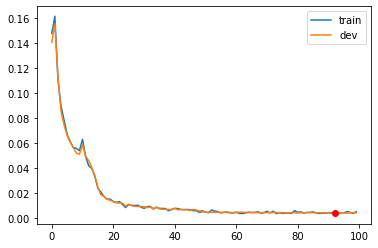

In [10]:
plt.plot(train_loss_list, label='train')
plt.plot(dev_loss_list, label='dev')
dev_index = np.argmin(dev_loss_list)
print(dev_index, dev_loss_list[dev_index])
plt.plot(dev_index, dev_loss_list[dev_index], 'ro')
plt.legend()
plt.show()

In [18]:
train_index = np.argmin(train_loss_list)
train_index, train_loss_list[train_index]

(93, tensor(0.0031, device='cuda:2', grad_fn=<MseLossBackward>))

## Run the best epoch

In [11]:
input_list = []
output_list = []

checkpoint_path = os.path.join(checkpoint_base_path, checkpoint_base_name + str(best_epoch))
# checkpoint_path = './associative_memory_checkpoint/pretrained_associative_memory'
checkpoint = torch.load(checkpoint_path)

snn.load_state_dict(checkpoint["snn_state_dict"])

print('Checkpoint: {} loaded'.format(checkpoint_path))

snn.eval()

test_loss_list = []

for i_batch, sample_batched in enumerate(test_dataloader):

    criterion = torch.nn.MSELoss()
    x_test = sample_batched[0].to(device)
    label = sample_batched[1].to(device)
    target_pattern = sample_batched[2].to(device)
    filtered_target_pattern = sample_batched[3].to(device)

    out_spike, filtered_out_spike = snn(x_test)

    loss = criterion(filtered_out_spike, filtered_target_pattern)
    test_loss_list.append(loss)
    print(i_batch, loss)

    input_list.append(x_test.cpu().detach().numpy())
    output_list.append(out_spike.cpu().detach().numpy())
print('test loss', sum(test_loss_list) / len(test_loss_list))

Checkpoint: ./associative_memory_checkpoint/associative_memory_checkpoint_92 loaded
0 tensor(0.0045, device='cuda:2', grad_fn=<MseLossBackward>)
1 tensor(0.0041, device='cuda:2', grad_fn=<MseLossBackward>)
2 tensor(0.0044, device='cuda:2', grad_fn=<MseLossBackward>)
3 tensor(0.0048, device='cuda:2', grad_fn=<MseLossBackward>)
4 tensor(0.0041, device='cuda:2', grad_fn=<MseLossBackward>)
5 tensor(0.0035, device='cuda:2', grad_fn=<MseLossBackward>)
6 tensor(0.0049, device='cuda:2', grad_fn=<MseLossBackward>)
7 tensor(0.0037, device='cuda:2', grad_fn=<MseLossBackward>)
8 tensor(0.0039, device='cuda:2', grad_fn=<MseLossBackward>)
9 tensor(0.0040, device='cuda:2', grad_fn=<MseLossBackward>)
10 tensor(0.0030, device='cuda:2', grad_fn=<MseLossBackward>)
11 tensor(0.0043, device='cuda:2', grad_fn=<MseLossBackward>)
12 tensor(0.0049, device='cuda:2', grad_fn=<MseLossBackward>)
13 tensor(0.0044, device='cuda:2', grad_fn=<MseLossBackward>)
14 tensor(0.0042, device='cuda:2', grad_fn=<MseLossBackwar

## Plot some samples

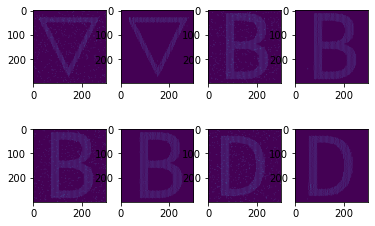

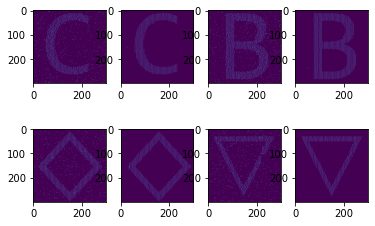

<Figure size 432x288 with 0 Axes>

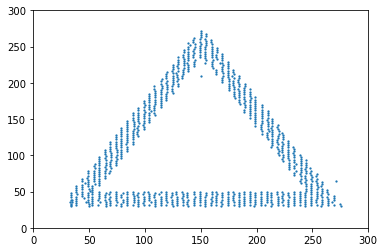

<Figure size 432x288 with 0 Axes>

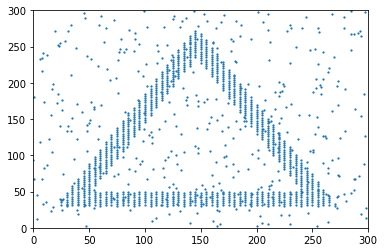

In [12]:
fig, axs = plt.subplots(2, 4)
axs[0, 0].imshow(input_list[0][0])
axs[0, 1].imshow(output_list[0][0])

axs[1, 0].imshow(input_list[0][1])
axs[1, 1].imshow(output_list[0][1])

axs[0, 2].imshow(input_list[0][2])
axs[0, 3].imshow(output_list[0][2])

axs[1, 2].imshow(input_list[0][3])
axs[1, 3].imshow(output_list[0][3])

fig, axs = plt.subplots(2, 4)
axs[0, 0].imshow(input_list[0][25])
axs[0, 1].imshow(output_list[0][25])

axs[1, 0].imshow(input_list[0][26])
axs[1, 1].imshow(output_list[0][26])

axs[0, 2].imshow(input_list[0][23])
axs[0, 3].imshow(output_list[0][23])

axs[1, 2].imshow(input_list[0][27])
axs[1, 3].imshow(output_list[0][27])

plt.figure()
utilities.plot_raster_dot(output_list[0][0])
plt.figure()
utilities.plot_raster_dot(input_list[0][0])

In [13]:
len(input_list), len(input_list[0]), len(output_list), len(output_list[0])

(31, 32, 31, 32)

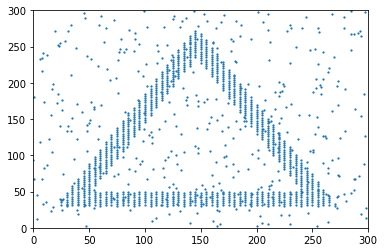

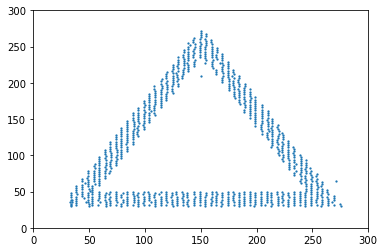

In [14]:
utilities.plot_raster_dot(input_list[0][0])
utilities.plot_raster_dot(output_list[0][0])

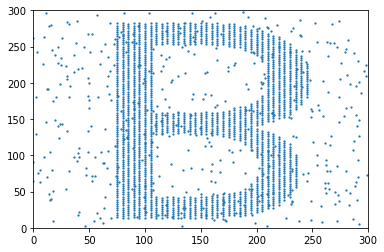

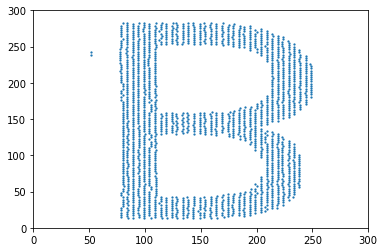

In [15]:
utilities.plot_raster_dot(input_list[0][2])
utilities.plot_raster_dot(output_list[0][2])

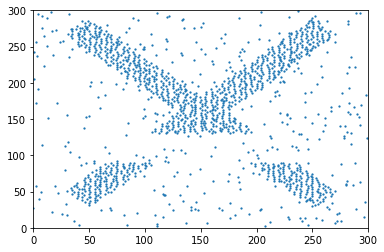

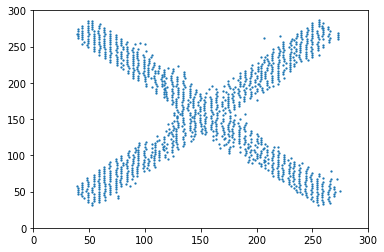

In [23]:
utilities.plot_raster_dot(input_list[0][8])
utilities.plot_raster_dot(output_list[0][8])

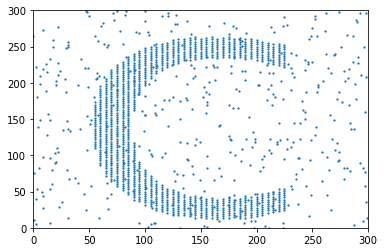

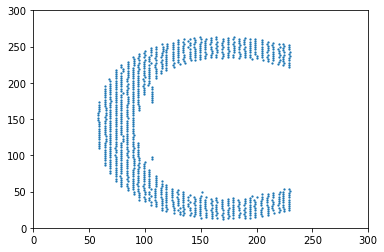

In [25]:
utilities.plot_raster_dot(input_list[10][1])
utilities.plot_raster_dot(output_list[10][1])